In [0]:
!pip install tensorboardcolab

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
tf.__version__


'1.15.0'

In [0]:
from tensorboardcolab import TensorBoardColab
from tensorboardcolab import TensorBoardColabCallback

In [0]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://9d8f70c9.ngrok.io


In [0]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

import os, sys, glob

In [0]:

def preprocessing(path, label): #path = '/content/drive/My Drive/medi/*'
  imglist = glob.glob(path) #폴더 안 사진 경로 읽기(5개 폴더), /content/drive/My Drive/medi/*
  img_label=[]
  img_array = []
  for i, name in enumerate(imglist):
    img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    img_resize = cv2.resize(img,(256,256))
    #ret, img_thres = cv2.threshold(img_resize, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_thres = cv2.adaptiveThreshold(img_resize, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,9, 3)
    img_thres = img_thres.astype('float32') / 255 # 0 ~ 1
    img_array.append(img_thres.reshape(256,256,1))
    img_label.append(label) #라벨번호
    
  return img_array, img_label

class_name = ['진단서', '입퇴원확인서','영수증','의무기록','수술기록지']
img_list1, imglist1_label = preprocessing('/content/drive/My Drive/medi/confirm/*', 0)
img_list2, imglist2_label = preprocessing('/content/drive/My Drive/medi/inout/*', 1)
img_list3, imglist3_label = preprocessing('/content/drive/My Drive/medi/receipt/*', 2)
img_list4, imglist4_label = preprocessing('/content/drive/My Drive/medi/record/*', 3)
img_list5, imglist5_label = preprocessing('/content/drive/My Drive/medi/surgery/*', 4) #???


In [0]:
print('진단서 :', len(img_list1))
print('입퇴원 확인서: ', len(img_list2))
print('영수증: ', len(img_list3))
print('의무기록: ', len(img_list4))
print('수술기록지: ', len(img_list5))

진단서 : 176
입퇴원 확인서:  55
영수증:  69
의무기록:  81
수술기록지:  68


In [0]:
#이미지 데이터셋 배열로 합치기
imgs = np.concatenate((img_list1,img_list2, img_list3, img_list4, img_list5))
imgs.shape

(449, 256, 256, 1)

In [0]:
#이미지 라벨
labels = np.concatenate((imglist1_label,imglist2_label, imglist3_label, imglist4_label,imglist5_label))
labels.shape

(449,)

In [0]:
val_size = int(imgs.shape[0] * 0.1)
print(val_size)

44


In [0]:
#train(80), test(10), val(10) 랜덤 split
from sklearn.model_selection import train_test_split
val_size = int(imgs.shape[0] * 0.1)
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size = 0.1)

x_val = x_train[:val_size]
y_val = y_train[:val_size]
x_train = x_train[val_size:]
y_train = y_train[val_size:]


In [0]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(256, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)


net = Conv2D(64, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(256)(net)
net = Activation('relu')(net)
net = Dense(128)(net)
net = Activation('relu')(net)
net = Dense(5)(net)
outputs = Activation('softmax')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
______________________________________________

In [0]:
history = model.fit(x_train, y_train, epochs = 50, batch_size = 16, validation_data=(x_val, y_val))

Train on 360 samples, validate on 44 samples
Epoch 1/50
360/360 [==============================] - 10s 27ms/sample - loss: 0.5992 - acc: 0.7639 - val_loss: 0.2594 - val_acc: 0.9545
Epoch 2/50
360/360 [==============================] - 1s 3ms/sample - loss: 0.3035 - acc: 0.9028 - val_loss: 0.2314 - val_acc: 0.9545
Epoch 3/50
360/360 [==============================] - 1s 3ms/sample - loss: 0.2815 - acc: 0.9222 - val_loss: 0.2422 - val_acc: 0.8864
Epoch 4/50
360/360 [==============================] - 1s 3ms/sample - loss: 0.2207 - acc: 0.9111 - val_loss: 0.1412 - val_acc: 0.9545
Epoch 5/50
360/360 [==============================] - 1s 3ms/sample - loss: 0.2543 - acc: 0.9139 - val_loss: 0.2076 - val_acc: 0.9318
Epoch 6/50
360/360 [==============================] - 1s 3ms/sample - loss: 0.2118 - acc: 0.9417 - val_loss: 0.1396 - val_acc: 0.9545
Epoch 7/50
360/360 [==============================] - 1s 3ms/sample - loss: 0.1608 - acc: 0.9444 - val_loss: 0.0513 - val_acc: 0.9773
Epoch 8/50
360/

KeyboardInterrupt: ignored

In [0]:
predict = model.predict(x_test)
predict_label = []
for i in range(len(predict)):
  predict_label.append(np.argmax(predict[i]))

In [0]:
predict[0]

array([9.9999499e-01, 4.9592286e-06, 8.7907850e-09, 8.3258339e-10,
       3.5399542e-10], dtype=float32)

In [0]:
np.mean(y_test== predict_label)

0.8888888888888888

In [0]:
len(history.history['loss'])

50

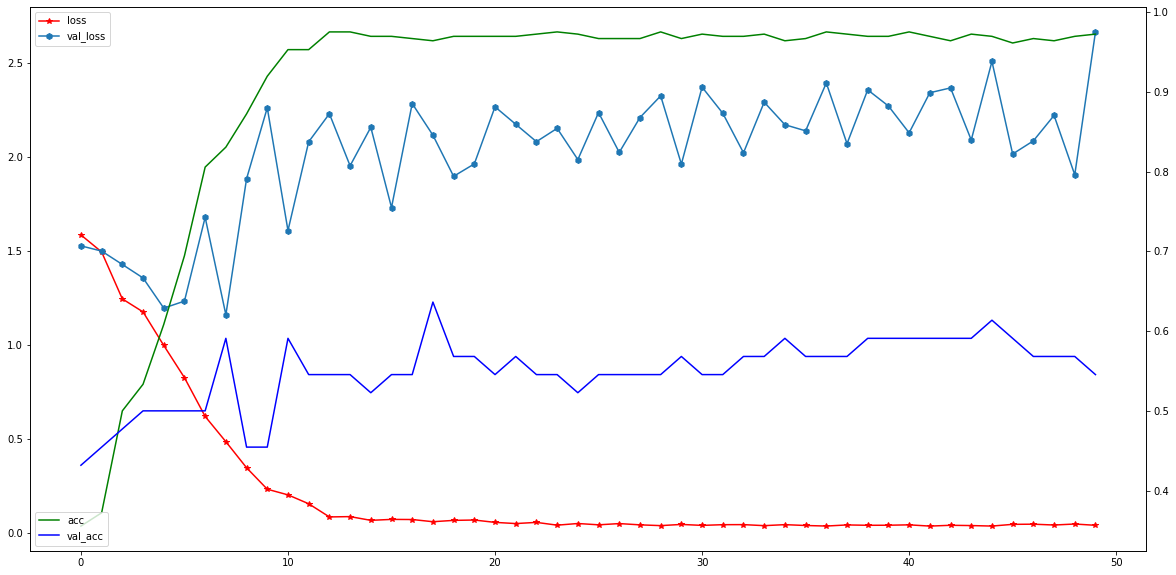

In [0]:
y_loss = history.history['loss']
x = np.arange(0, len(y_loss))
y_val_loss = history.history['val_loss']
y_acc = history.history['accuracy']
y_val_acc = history.history['val_accuracy']
fig, axes = plt.subplots(figsize=(20,10))
axes.plot(x, y_loss, marker = '*', color = 'red', label = 'loss')
axes.plot(x, y_val_loss, marker='h' ,label = 'val_loss')
another = axes.twinx()
another.plot(x, y_acc, color = 'green', label = "acc")
another.plot(x, y_val_acc, color = 'blue', label = "val_acc" )
axes.legend(loc = 'upper left')
another.legend(loc='lower left')
plt.show()
fig.figsave

In [0]:
ii = cv2.imread('recep.jpg', cv2.IMREAD_GRAYSCALE)
resize = cv2.resize(ii, (256,256))

In [0]:
img = resize.reshape(1,256,256,1)

In [0]:
pr=model.predict(img)

In [0]:
pr

array([[0., 0., 0., 0., 1.]], dtype=float32)

In [0]:
class_name[4]

In [0]:
lists = glob.glob('/content/drive/My Drive/medi/confirm/*')

In [0]:
for i, name in enumerate(lists):
  print(name)

/content/drive/My Drive/medi/confirm/ia_700000004.png
/content/drive/My Drive/medi/confirm/ia_300000007.png
/content/drive/My Drive/medi/confirm/ia_300000001.png
/content/drive/My Drive/medi/confirm/ia_300000008.jpeg
/content/drive/My Drive/medi/confirm/ia_300000004.png
/content/drive/My Drive/medi/confirm/ia_300000006.png
/content/drive/My Drive/medi/confirm/ia_300000003.png
/content/drive/My Drive/medi/confirm/ia_300000002.jpeg
/content/drive/My Drive/medi/confirm/ia_300000005.jpeg
/content/drive/My Drive/medi/confirm/ia_300000010.jpeg
/content/drive/My Drive/medi/confirm/ia_300000011.jpeg
/content/drive/My Drive/medi/confirm/ia_300000025.jpg
/content/drive/My Drive/medi/confirm/ia_300000021.png
/content/drive/My Drive/medi/confirm/ia_300000018.png
/content/drive/My Drive/medi/confirm/ia_300000012.jpeg
/content/drive/My Drive/medi/confirm/ia_300000013.png
/content/drive/My Drive/medi/confirm/ia_300000023.jpg
/content/drive/My Drive/medi/confirm/ia_300000014.jpeg
/content/drive/My Dri